In [3]:
import pandas as pd
from pandas import Timestamp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import datetime

from IPython.display import display, HTML,clear_output

from scipy.interpolate import interp1d
from scipy import stats

from statsmodels.tsa.seasonal import STL
pd.set_option('display.max_columns', None)


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error

# Data Prep

In [4]:
all_data = pd.DataFrame()

# CSV files are in a subdirectory called Hiscores 
# 'Hi'scores used instead of 'High'scores to copy original data naming convention
# https://secure.runescape.com/m=hiscore_oldschool/overall
for file in os.listdir('Hiscores'):
    c += 1
    # Load the data and get the full path to the file
    full_path = os.path.abspath(file)
    full_path = '\\'.join(full_path.split('\\')[:-1]) + '\\Hiscores\\' + file
    data = pd.read_csv(full_path)
    
    # Find any missing values and inject the average of the surrounding dates
    missing_values = list(data[data['Last_Record_rank'].isna()].index)
    for index in missing_values:
        x = data['Last_Record_rank'].iloc[index-1]
        y = data['Last_Record_rank'].iloc[index+1]
        value = (x + y) / 2
        data.at[index,'Last_Record_rank'] = value
    
    # Determine if there are any missing dates
    data['Date'] = pd.to_datetime(data['Date'])
    missing_dates = pd.DataFrame({'Date':data.Date,'diff':data.Date.shift(-1)-data.Date})
    missing_dates = missing_dates[(missing_dates['diff'] != '1 day') &
                                  (~pd.isnull(missing_dates['diff']))]
    
    # For any missing date interpolate the missing values
    for ind,row in missing_dates.iterrows():
        
        next_date = (row['Date']+datetime.timedelta(days=1)).strftime('%Y-%m-%d')
        
        # Compute the starting point where data exists, i.e. 2022-01-01
        start_value_index = data[data['Date'] == row['Date']]['Last_Record_rank'].index[0]
        start_value = data[data['Date'] == row['Date']]['Last_Record_rank'].iloc[0]
        start_value_date = data[data['Date'] == row['Date']]['Date'].iloc[0]
        
        # Compute the ending point where data exists, i.e. 2022-01-03
        end_value_index = start_value_index+1
        end_value = data.iloc[end_value_index]['Last_Record_rank']
        end_value_date = data.iloc[end_value_index]['Date']
        
        # Compute the total number of days in the calculation including the missing days
        # i.e. [2022-01-01,2022-01-02,2022-01-03] = 3 days
        num_total_dates = int(str(row['diff']).split()[0])+1
        
        # Interpolate between the start and end date using the num_total_dates 
        # to determine how many new values are needed.
        # Remove the start and end values and keep the new, interpolated values.
        interpolation = [int(x) for x in np.linspace(start_value, end_value, num_total_dates)][1:-1]
        
        # Create any new rows using placeholder values
        new_df = pd.DataFrame()
        for count,value in enumerate(interpolation):
            
            for col in data.columns:
                if col not in ['Date','Boss','Type','Last_Record_rank']:
                    new_df.at[count,col] = 0
                elif col == 'Date':
                    new_df.at[count,'Date'] = start_value_date + datetime.timedelta(days=(count+1))
                elif col == 'Last_Record_rank':
                    new_df.at[count,'Last_Record_rank'] = value
                else:
                    new_df.at[count,col] = data[col].unique()[0]
        
        # Add any new rows to the full dataset
        if len(new_df)>0:
            data = pd.concat([data,new_df],axis=0).sort_values('Date').reset_index(drop=True)
        
    # Label the type of data
    for col in data.columns:
        if 'score' in col:
            data['Type'] = 'Boss'
            data['Boss'] = file.replace('.csv','').replace('_Hiscores','').replace('_',' ')
            # Add the data to the aggregated file
            all_data = pd.concat([all_data,data],axis=0)
            break
        elif 'level' in col:
            data['Type'] = 'Skill'
            break

# Seasonal Decomposition

Dagannoth Rex


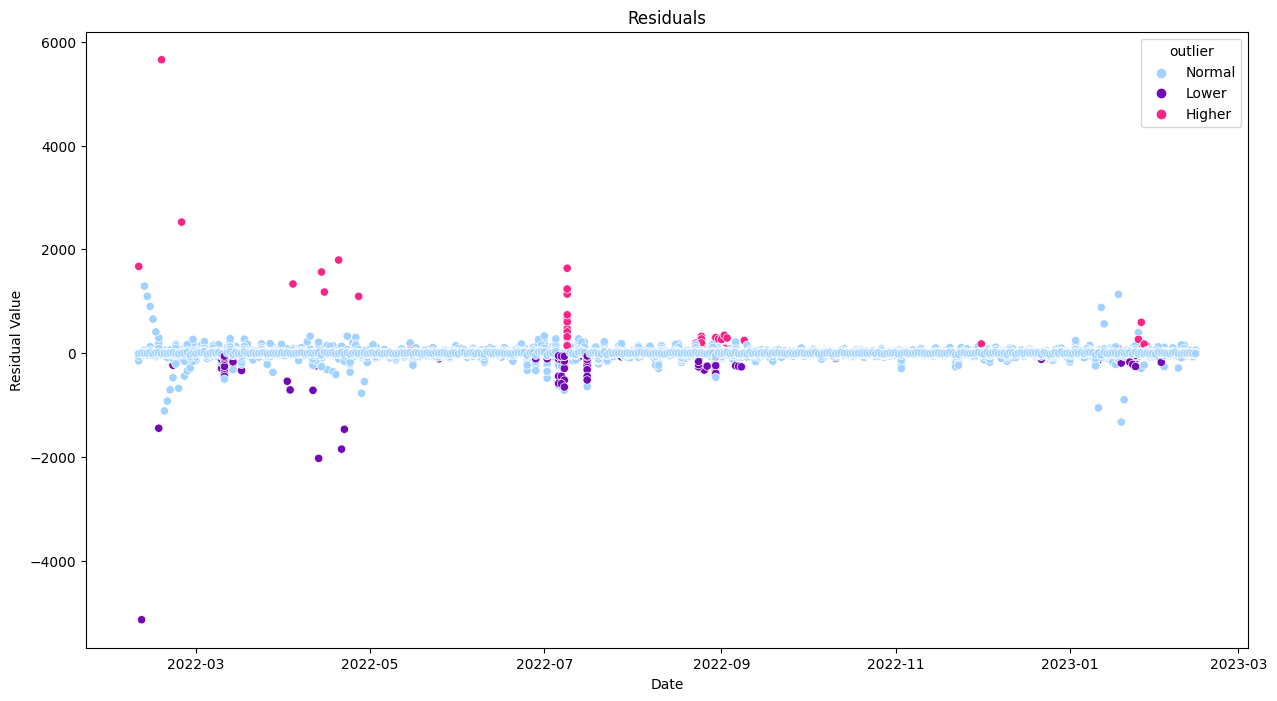

In [5]:
residuals = pd.DataFrame()

# For each boss
for boss in all_data['Boss'].unique():
    data = all_data[all_data['Boss'] == boss].copy()
    
    # Determine the differences day over day
    data['diff'] = data['Last_Record_rank'].diff(1)
    data.at[0,'diff'] = 0
    
    data['Date'] = pd.to_datetime(data['Date'])
    
    data.set_index('Date',inplace=True)
    try:
        # Compute the STL using weekly seasonality
        res = STL(data['diff'], seasonal=7).fit()
        f = res.resid.to_frame()
        f['outlier'] = 'Normal'
        # Compute outliers where Z score larger than 3 standard deviations
        f.loc[stats.zscore(f['resid']) <=-3,'outlier'] = 'Lower'
        f.loc[stats.zscore(f['resid']) >= 3,'outlier'] = 'Higher'
        f['Boss'] = boss

        residuals = pd.concat([f,residuals])
    except:
        print(boss)
    
# Plot all of the residual values and mark the outliers
plt.figure(figsize=(15,8),dpi=100)
plt.title('Residuals')
plt.ylabel('Residual Value')
sns.scatterplot(data=residuals,x='Date',y='resid',hue='outlier',palette= ["#a2d2ff", "#7209b7", '#f72585'])
plt.show();
    

# Plot Outlier Trends

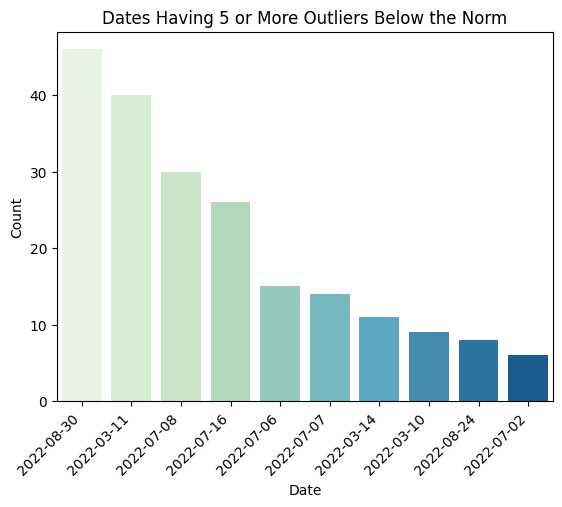

In [6]:
res = residuals[residuals['outlier'] == 'Lower'].reset_index()
t = res['Date'].value_counts().to_frame().reset_index()
t.columns = ['Date','Count']
t['Date'] = pd.to_datetime(t['Date'])
t['Date'] = t['Date'].dt.strftime('%Y-%m-%d')
sns.barplot(data=t[t['Count']>4],x='Date',y='Count',palette='GnBu')
plt.title('Dates Having 5 or More Outliers Below the Norm')
plt.xticks(
    rotation=45,
    horizontalalignment='right');

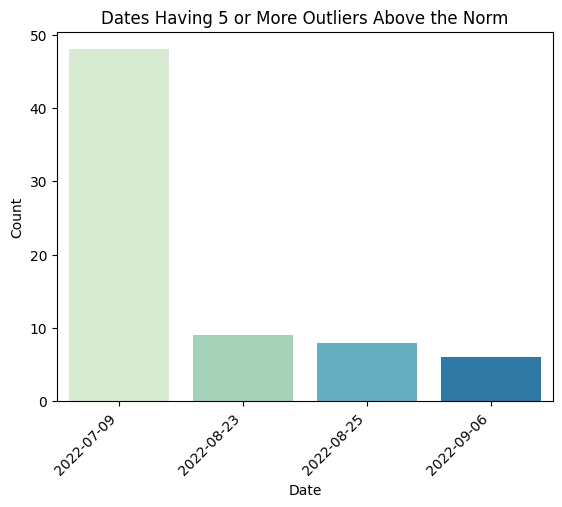

In [7]:
res = residuals[residuals['outlier'] == 'Higher'].reset_index()
t = res['Date'].value_counts().to_frame().reset_index()
t.columns = ['Date','Count']
t['Date'] = pd.to_datetime(t['Date'])
t['Date'] = t['Date'].dt.strftime('%Y-%m-%d')
sns.barplot(data=t[t['Count']>4],x='Date',y='Count',palette='GnBu')
plt.title('Dates Having 5 or More Outliers Above the Norm')
plt.xticks(
    rotation=45,
    horizontalalignment='right');

# Forecasting

## ARIMA Forecast

In [9]:
def arima_results(load_from_file=True):
    if load_from_file:
#         try:
        arima_res = pd.read_csv('ARIMA_Best_Models.csv')
        return arima_res
        arima_res['Date'] = pd.to_datetime(arima_res['Date'])
        return arima_res
#         except:
#             pass
    
    # boss:parameters
    results = pd.DataFrame()

    for boss_index,(boss_name,data) in enumerate(all_data.groupby('Boss')[['Date','Last_Record_rank']]):

        lrr = data['Last_Record_rank'].copy()

        # Calculate d value (how much smoothing)
        new_lrr = lrr.copy()
        adfuller_pval = adfuller(new_lrr)[1]

        d_val = 0

        # if the p value is significant it means there is
        # NO stationarity and the data should be differenced
        while adfuller_pval <= 0.05:
            new_lrr = new_lrr.diff().dropna()
            d_val += 1
            if d_val > 2:
                d_val = 1
                print(i)
                break


        pv,dv,qv = range(0,7),[d_val],range(0,7)

        # calculate all p,d,q permutations, removing the first value which will have a p and q of 0
        permutations = list(itertools.product(pv,dv,qv))[1:]

        days_to_predict = 30

        # Column Instantiation
        best_params = (0,0,0)
        last_n_days_actual = list(lrr[-days_to_predict:])
        last_n_days_dates = list(data['Date'][-days_to_predict:])
        last_n_days_predictions = []
        best_mse = 999999999

        X_data = lrr[:-days_to_predict]

        for count,(p,d,q) in enumerate(permutations):
            clear_output(wait=True)
            print(f'{boss_index}/{len(all_data.groupby("Boss"))}')
            print(f'{round(count/len(permutations)*100,0)}%')

            mse = 999999999
            try:
                arima = SARIMAX(X_data,order=(p,d,q)).fit(disp=False)

                predictions = list(arima.predict(start=len(X_data),end=len(lrr)-1))

                mse = mean_squared_error(last_n_days_actual,predictions)

            except:
    #             print(f'err {p,d,q}')
                pass

            if mse < best_mse:
                best_mse = mse
                best_params = (p,d,q)
                last_n_days_predictions = predictions

        boss_results = pd.DataFrame({'Boss':[boss_name],
                                     'Best_Parameters':[best_params],
                                     'Actuals':[last_n_days_actual],
                                     'Predictions':[last_n_days_predictions],
                                     'Dates':[last_n_days_dates],
                                     'MSE':[best_mse]})
        results = pd.concat([results,boss_results],axis=0)
        clear_output(wait=True)
        
    results.to_csv('ARIMA_Best_Models.csv',index=False)
    return results

In [10]:
arima_res = arima_results()

## SARIMA Forecast

In [13]:
def sarima_results(load_from_file=True):
    
    if load_from_file:
        results = pd.DataFrame()
        for file in os.listdir('SARIMA_Results/'):
            results = pd.concat([results,pd.read_csv(f'SARIMA_Results/{file}')])
        
        return results
    
    # boss:parameters
    results = pd.DataFrame()

    start = True
    for boss_index,(boss_name,data) in enumerate(all_data.groupby('Boss')[['Date','Last_Record_rank']]):
        
#         if boss_name == '':
#             start = True
            
        if start:
            lrr = data['Last_Record_rank'].copy()

            # Calculate d value (how much smoothing)
            new_lrr = lrr.copy()
            adfuller_pval = adfuller(new_lrr)[1]

            d_val = 0

            # if the p value is significant it means there is
            # NO stationarity and the data should be differenced
            while adfuller_pval <= 0.05:
                new_lrr = new_lrr.diff().dropna()
                d_val += 1
                if d_val > 2:
                    d_val = 1
                    print(boss_name)
                    break


            pv,dv,qv,Pv,Dv,Qv = range(0,7),[d_val],range(0,7),range(0,3),[0],range(0,3)

            # calculate all p,d,q permutations, removing the first value which will have a p and q of 0
            perms = list(itertools.product(pv,dv,qv,Pv,Dv,Qv))#[1:]

            permutations = []

            for pv,dv,qv,Pv,Dv,Qv in perms:
                if Pv == 0 and Qv == 0:
                    pass
                else:
                    permutations.append((pv,dv,qv,Pv,Dv,Qv))


            print(len(permutations))
            days_to_predict = 30

            # Column Instantiation
            best_params = (0,0,0)
            last_n_days_actual = list(lrr[-days_to_predict:])
            last_n_days_dates = list(data['Date'][-days_to_predict:])
            last_n_days_predictions = []
            best_mse = 999999999

            X_data = lrr[:-days_to_predict]

            for count,(p,d,q,P,D,Q) in enumerate(permutations):
                clear_output(wait=True)
                print(boss_name)
                print(f'{boss_index}/{len(all_data.groupby("Boss"))}')
                print(f'{round(count/len(permutations)*100,0)}%')

                mse = 999999999
                try:
                    sarima = SARIMAX(X_data,order=(p,d,q),seasonal_order=(P,D,Q,7)).fit(disp=False)

                    predictions = list(sarima.predict(start=len(X_data),end=len(lrr)-1))

                    mse = mean_squared_error(last_n_days_actual,predictions)

                except Exception as e:
        #             print(f'err {p,d,q,P,D,Q}')
                    pass

                if mse < best_mse:
                    best_mse = mse
                    best_params = (p,d,q,P,D,Q)
                    last_n_days_predictions = predictions

            boss_results = pd.DataFrame({'Boss':[boss_name],
                                         'Best_Parameters':[best_params],
                                         'Actuals':[last_n_days_actual],
                                         'Predictions':[last_n_days_predictions],
                                         'Dates':[last_n_days_dates],
                                         'MSE':[best_mse]})

            boss_results.to_csv(f'SARIMA_Results/SARIMA_Best_Models_{boss_name}.csv',index=False)

            clear_output(wait=True)
    
    
    return

In [14]:
sarima_res = sarima_results()

## LSTM Forecast

In [15]:
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,InputLayer,Dropout
# import tensorflow as tf

In [20]:
def lstm_results(start_at_boss=None,load_from_file=True):
    # Load data from file 
    if load_from_file:
        results = pd.DataFrame()
        for file in os.listdir('LSTM_Results/'):
            results = pd.concat([results,pd.read_csv(f'LSTM_Results/{file}')])

        return results
    
    
    if start_at_boss:
        start = False
    else:
        start = True
    for boss_index,(boss_name,data) in enumerate(all_data.groupby('Boss')[['Date','Last_Record_rank']]):
        
        if start_at_boss:
            if boss_name == start_at_boss:
                start = True
        
            
        if start:
            print(boss_name)
            def build_dataset(data,slice_length=5):
                X = []
                y = []
                dates = []
                for i,row in data.iterrows():
                    if i+slice_length < len(data)-1:
                        X.append(data.iloc[i:i+slice_length]['Last_Record_rank'])
                        y.append(data.iloc[i+slice_length+1]['Last_Record_rank'])

                return np.array(X),np.array(y)

            X,y = build_dataset(data,slice_length=7)

            dates = data['Date'].to_list()

            num_days_to_predict = 30

            X_train,y_train = X[0:-num_days_to_predict],y[0:-num_days_to_predict]
            X_test,y_test = X[-num_days_to_predict:],y[-num_days_to_predict:]

            num_features = 1

            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], num_features)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], num_features)
            
            shape = X_train.shape[1:]

            model = Sequential()
            model.add(LSTM(32, activation = 'relu', input_shape=shape))
            model.add(Dense(16,'relu'))
            model.add(Dense(8,'relu'))
            model.add(Dense(1,'linear'))


            model.compile(loss=MeanSquaredError(),
                          optimizer=Adam(learning_rate=0.0001),
                          metrics=[RootMeanSquaredError()])

            history = model.fit(X_train,y_train,epochs=100,batch_size=1,verbose=3)

            preds = []

            last_n_days = [x[0] for x in X_test[0]]
            print(last_n_days)
            for i in range(len(X_test)):
                pred = int(model.predict([last_n_days],verbose=3)[0][0])
                preds.append(pred)
                last_n_days.append(pred)
                del last_n_days[0]

            mse = mean_squared_error(y_test,preds)

            boss_results = pd.DataFrame({'Boss':[boss_name],
                                         'Best_Parameters':['LSTM(32),Dense(16),Dense(8),Dense(1)'],
                                         'Actuals':[y_test],
                                         'Predictions':[preds],
                                         'Dates':[dates[-num_days_to_predict:]],
                                         'MSE':[mse]})

            print('Complete')
            boss_results.to_csv(f'LSTM_Results/LSTM_Best_Models_{boss_name}.csv',index=False)
        
        
lstm_res = lstm_results()

## Example Comparison

In [31]:
arima_res['Model'] = 'ARIMA'
sarima_res['Model'] = 'SARIMA'
lstm_res['Model'] = 'LSTM'
lstm_res['Actuals'] = arima_res['Actuals']

In [32]:
merged = pd.concat([arima_res,sarima_res,lstm_res])

In [33]:
merged[merged['Boss'] == 'Abyssal Sire']

,Boss,Best_Parameters,Actuals,Predictions,Dates,MSE,Model
0,Abyssal Sire,"(5, 0, 2)","[142495.0, 142591.0, 142681.0, 142789.0, 14290...","[142487.64411736658, 142599.48465212132, 14269...","[Timestamp('2023-01-16 00:00:00'), Timestamp('...",24410.019509,ARIMA
0,Abyssal Sire,"(1, 0, 6, 2, 0, 2)","[142495.0, 142591.0, 142681.0, 142789.0, 14290...","[142502.176526643, 142604.4443663766, 142712.4...","[Timestamp('2023-01-16 00:00:00'), Timestamp('...",13912.864407,SARIMA
0,Abyssal Sire,"LSTM(32),Dense(16),Dense(8),Dense(1)","[142495.0, 142591.0, 142681.0, 142789.0, 14290...","[142398, 142464, 142537, 142608, 142717, 14282...","[Timestamp('2023-01-16 00:00:00'), Timestamp('...",190494.700000,LSTM


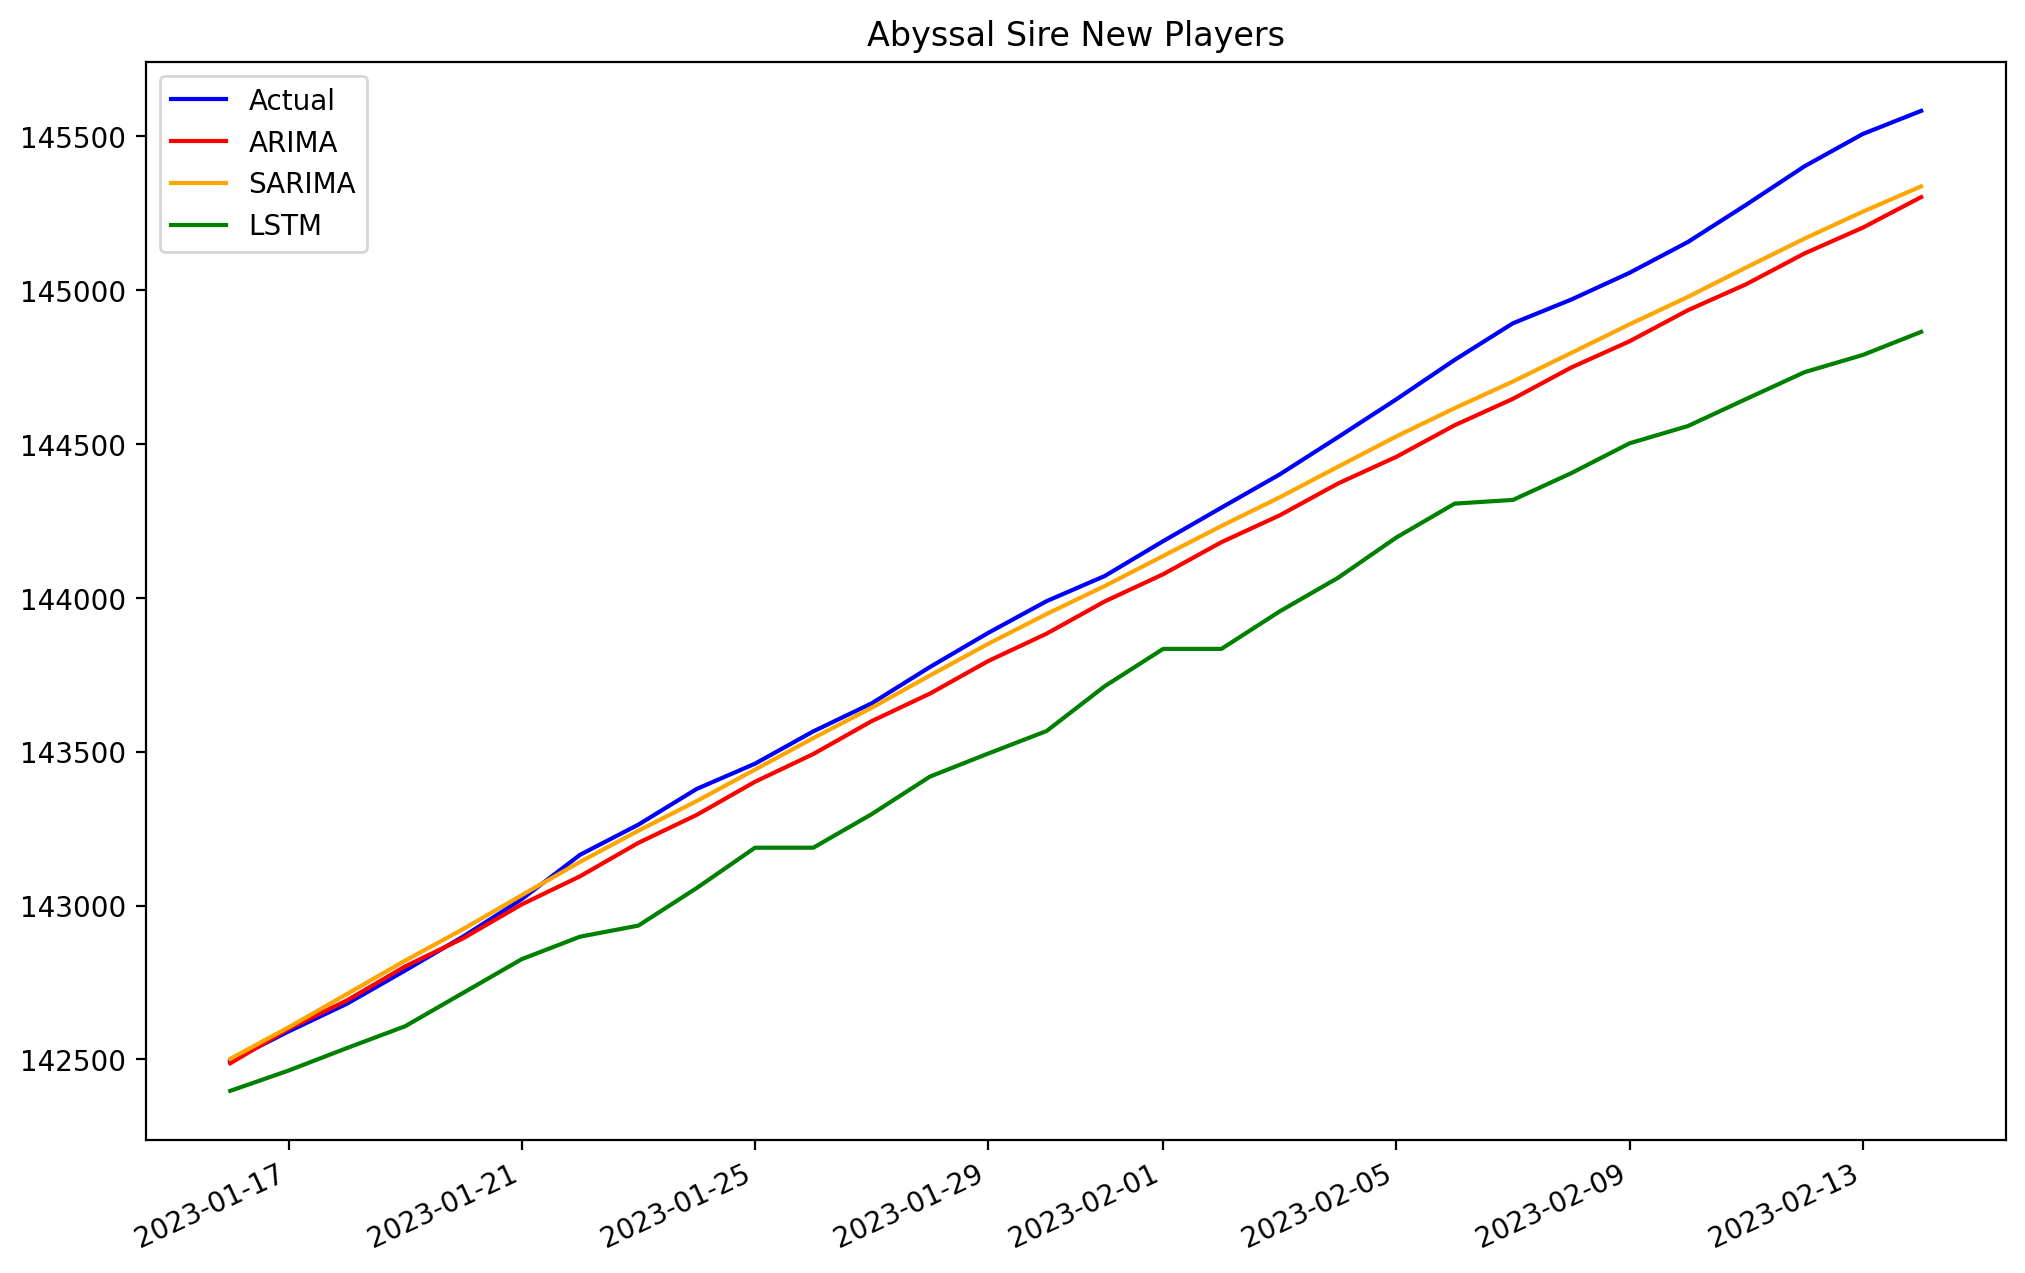

In [55]:
plt.figure(figsize=(12,7),dpi=200)
boss = 'Abyssal Sire'
plt.title(f'Forecasted New Players for {boss}')

colors = ['Blue','Red','Orange','Green']
color_iter = iter(colors)

actuals_graphed = False
for model in merged['Model'].unique():
    
    subset = merged[(merged['Boss'] == boss) &
                    (merged['Model'] == model)]
    
    if not actuals_graphed:
        actuals_graphed = True
        sns.lineplot(x=eval(subset['Dates'].to_list()[0]),
                     y=eval(subset['Actuals'].to_list()[0]),
                     color=next(color_iter),
                     label='Actual')
    
    sns.lineplot(x=eval(subset['Dates'].to_list()[0]),
                 y=eval(subset['Predictions'].to_list()[0]),
                 color=next(color_iter),
                 label=model)

plt.xticks(
    rotation=25,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)

plt.legend()
plt.show()